# An adaptive ensemble framework for addressing concept drift in IoT data streams
This is the code for the paper entitled "**An adaptive ensemble framework for addressing concept drift in IoT data streams**"   <br>
Authors: Yafeng Wu (neverland0504@163.com), Lan Liu (liulan@gpnu.edu.cn), Yongjie Yu, Guiming Chen, Junhan Hu  <br>
Organization: School of Cybersecurity and Information Engineering, Guangdong Polytechnic Normal University

# 1. Load Data and Define Functions

## Import libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install river==0.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 848.6/848.6 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for river: filename=river-0.10.1-cp310-cp310-linux_x86_64.whl size=2102625 sha256=4c6cb3e206ce5d68e9249823062b6049899858bc0d576f59f0d484f7e05a6d6a
  Stored in directory: /root/.cache/pip/wheels/ca/8e/67/2a975aa30c8517b43e5e03cff2f523a9c659688afe5f21e407
Successfully built river


In [ ]:
!pip install optunity

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for optunity: filename=Optunity-1.1.1-py3-none-any.whl size=72030 sha256=d9e7ef42d9926924e72a083301469c61bd0ac6701950f4f88cebbece87aeee93
  Stored in directory: /root/.cache/pip/wheels/83/98/40/b9956c3386a045f035f9edbf894edd04713db92f29fb58a225
Successfully built optunity


In [ ]:
!cat /proc/cpuinfo | grep 'model name'
!cat /proc/meminfo | grep 'MemTotal'

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
MemTotal:       13294264 kB


## Dataset 2: IoTID20
A subset of the IoT network traffic data randomly sampled from the [IoTID20 dataset](https://sites.google.com/view/iot-network-intrusion-dataset/home). And then normalized by Z-score.

In [ ]:
df = pd.read_csv("/content/drive/My Drive/AEWAE/Data/IoT_2020_b_n_0.01.csv")
# df = df.sample(n=None, frac=0.1, replace=False, weights=None, random_state=None, axis=0)
# df = df.sort_index()

In [ ]:
df

,Flow_ID,Src_IP,Src_Port,Dst_IP,Dst_Port,Timestamp,Flow_Duration,TotLen_Fwd_Pkts,TotLen_Bwd_Pkts,Bwd_Pkt_Len_Max,...,Fwd_Pkts/s,Bwd_Pkts/s,Pkt_Len_Std,FIN_Flag_Cnt,Pkt_Size_Avg,Init_Bwd_Win_Byts,Idle_Mean,Idle_Max,Idle_Min,Label
0,-0.726692,0.247350,0.741495,-0.182331,-0.410798,1.033197,-0.148431,-0.523074,1.613986,1.027625,...,-0.313902,-0.146424,-0.413002,-0.030994,1.239575,-0.349773,-0.202192,-0.160693,-0.210739,1
1,-1.323099,0.247053,1.030748,-2.080324,-0.483542,0.923317,12.537535,1.788528,-0.796537,-0.969179,...,-0.313633,-0.339937,2.492231,-0.030994,-0.288412,-0.498430,7.666017,13.801076,0.854149,1
2,-0.727305,0.247053,-1.041159,-0.119065,2.113255,-0.450689,-0.162476,0.746112,0.408724,1.027625,...,-0.228863,-0.175662,-0.413002,-0.030994,1.239575,-0.349773,-0.228467,-0.178449,-0.241147,1
3,-0.727541,0.247350,0.722406,-0.182331,-0.410798,-0.745684,-0.141546,-0.523074,-0.796537,-0.969179,...,-0.230575,-0.259719,-0.413002,-0.030994,-0.954404,2.277943,-0.227695,-0.177753,-0.240551,1
4,-0.727541,0.247350,0.722406,-0.182331,-0.410798,-0.803099,-0.159722,-0.523074,-0.796537,-0.969179,...,-0.239109,-0.195517,-0.413002,-0.030994,-0.954404,2.256024,-0.223315,-0.174967,-0.235185,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6247,-0.729002,0.247350,-0.996562,-0.182331,-0.410798,-1.642549,-0.163303,-0.523074,1.613986,1.027625,...,-0.313902,0.003260,-0.413002,-0.030994,1.239575,-0.349773,-0.230013,-0.179494,-0.242936,1
6248,-0.679538,0.247053,1.022717,0.513600,-0.417784,0.542198,-0.171564,-0.406031,-0.768750,-0.923143,...,0.306881,-0.039705,-0.413002,-0.030994,-0.913939,-0.509261,-0.260925,-0.196554,-0.281692,1
6249,-0.964963,-0.766846,-1.062670,-0.182331,-0.899570,0.970833,0.170749,-0.523074,-0.796537,-0.969179,...,-0.313902,-0.321705,-0.413002,-0.030994,-0.954404,0.736025,0.394917,0.242831,0.480306,1
6250,1.630458,0.247646,1.209377,0.513600,-0.354912,0.470924,-0.121443,-0.435292,-0.768750,-0.923143,...,-0.230012,-0.286268,-0.413002,-0.030994,-0.912253,-0.509261,-0.227952,-0.132143,-0.279903,1


In [ ]:
print(df['Label'].value_counts())

1    5891
0     361
Name: Label, dtype: int64


## Train-test split
10% training set, and 90% test set

In [ ]:
X = df.drop(['Label'],axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.1, test_size = 0.9, shuffle=False,random_state = 0)

## Define Functions

In [ ]:
# Import the online learning metrics and algorithms from the River library
from river import metrics
from river import stream
from river import tree,neighbors,naive_bayes,ensemble,linear_model
from river.drift import DDM, ADWIN,EDDM,HDDM_A,HDDM_W,KSWIN,PageHinkley

In [ ]:
# Define a generic adaptive learning function
# The argument "model" means an online adaptive learning algorithm
def adaptive_learning(model, X_train, y_train, X_test, y_test):
    metric = metrics.Accuracy() # Use accuracy as the metric
    i = 0 # count the number of evaluated data points
    t = [] # record the number of evaluated data points
    m = [] # record the real-time accuracy
    yt = [] # record all the true labels of the test set
    yp = [] # record all the predicted labels of the test set

    eddm = EDDM()

    # Learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        model.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred= model.predict_one(xi)  # Predict the test sample
        model.learn_one(xi,yi) # Learn the test sample
        metric = metric.update(yi, y_pred) # Update the real-time accuracy

        #drift_detection part
        val = 0
        if yi != y_pred:
            val = 1
        in_drift, in_warning = eddm.update(float(val)) #val=0：y_pred和yi相等，反之则不等。以val为参数，仅仅表明是否相等。EDDM会在内部更新各种内部变量，如均值、标准差。根据更新的变量和阈值，来判断是在warning还是在drift。
        if in_drift:
            print(f"Change detected at index {i}")

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)
        i = i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

In [ ]:
# Define a figure function that shows the real-time accuracy changes
def acc_fig(t, m, name):
    plt.rcParams.update({'font.size': 15})
    plt.figure(1,figsize=(10,6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(t,m,'-b',label='Avg Accuracy: %.2f%%'%(m[-1]))

    plt.legend(loc='best')
    plt.title(name+' on IoTID20 dataset', fontsize=15)
    plt.xlabel('Number of samples')
    plt.ylabel('Accuracy (%)')

    plt.draw()

# 2.AEWAE method Development

## Define the AEWAE method

In [ ]:
def AEWAE(X_train, y_train, X_test, y_test, alpha):
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    cumulative_error1 = 0
    cumulative_error2 = 0
    cumulative_error3 = 0
    cumulative_error4 = 0

    i = 0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
    hat4 = linear_model.PAClassifier() # OPA

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1, yi1)
        hat2.learn_one(xi1, yi1)
        hat3.learn_one(xi1, yi1)
        hat4.learn_one(xi1, yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred1 = hat1.predict_one(xi)
        y_prob1 = hat1.predict_proba_one(xi)
        hat1.learn_one(xi, yi)

        y_pred2 = hat2.predict_one(xi)
        y_prob2 = hat2.predict_proba_one(xi)
        hat2.learn_one(xi, yi)

        y_pred3 = hat3.predict_one(xi)
        y_prob3 = hat3.predict_proba_one(xi)
        hat3.learn_one(xi, yi)

        y_pred4 = hat4.predict_one(xi)
        y_prob4 = hat4.predict_proba_one(xi)
        hat4.learn_one(xi, yi)

        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)

        error1 = 1 if y_pred1 != yi else 0
        error2 = 1 if y_pred2 != yi else 0
        error3 = 1 if y_pred3 != yi else 0
        error4 = 1 if y_pred4 != yi else 0

        cumulative_error1 = alpha * cumulative_error1 + (1 - alpha) * error1
        cumulative_error2 = alpha * cumulative_error2 + (1 - alpha) * error2
        cumulative_error3 = alpha * cumulative_error3 + (1 - alpha) * error3
        cumulative_error4 = alpha * cumulative_error4 + (1 - alpha) * error4

        ewa_error_rate1 = cumulative_error1 / (1 - alpha ** (i + 1))
        ewa_error_rate2 = cumulative_error2 / (1 - alpha ** (i + 1))
        ewa_error_rate3 = cumulative_error3 / (1 - alpha ** (i + 1))
        ewa_error_rate4 = cumulative_error4 / (1 - alpha ** (i + 1))

        # Calculating the weights of base classifiers
        ep = 0.001
        ea = 1 / (ewa_error_rate1 + ep) + 1 / (ewa_error_rate2 + ep) + 1 / (ewa_error_rate3 + ep) + 1 / (
                ewa_error_rate4 + ep)
        w1 = 1 / (ewa_error_rate1 + ep) / ea
        w2 = 1 / (ewa_error_rate2 + ep) / ea
        w3 = 1 / (ewa_error_rate3 + ep) / ea
        w4 = 1 / (ewa_error_rate4 + ep) / ea

        # Calculating the probabilities of each class
        ypro10 = y_prob1.get(0, 0)
        ypro11 = y_prob1.get(1, 0)

        ypro20 = y_prob2.get(0, 0)
        ypro21 = y_prob2.get(1, 0)

        ypro30 = y_prob3.get(0, 0)
        ypro31 = y_prob3.get(1, 0)

        ypro40 = y_prob4.get(0, 0)
        ypro41 = y_prob4.get(1, 0)

        # Calculate the final probability and make a prediction
        y_prob_0 = w1 * ypro10 + w2 * ypro20 + w3 * ypro30 + w4 * ypro40
        y_prob_1 = w1 * ypro11 + w2 * ypro21 + w3 * ypro31 + w4 * ypro41

        if y_prob_0 > y_prob_1:
            y_pred = 0
        else:
            y_pred = 1

        # Updating the real-time accuracy of the overall model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)

        i = i + 1

    print("Accuracy: " + str(round(accuracy_score(yt, yp), 4) * 100) + "%")
    print("Precision: " + str(round(precision_score(yt, yp), 4) * 100) + "%")
    print("Recall: " + str(round(recall_score(yt, yp), 4) * 100) + "%")
    print("F1-score: " + str(round(f1_score(yt, yp), 4) * 100) + "%")

    return t, m

## Hyperparameter optimization by BO-TPE

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
def aewae_bo(params):
    alpha = params['alpha']
    t, m = AEWAE(X_train, y_train, X_test, y_test, alpha)


    accuracy = m[-1] / 100
    print(f"Alpha: {alpha}, Accuracy: {accuracy * 100}%")
    return {'loss': -accuracy, 'status': STATUS_OK}


In [ ]:
space = {
    'alpha': hp.uniform('alpha', 0.001, 1.0),
}
t1 = time.time()
best = fmin(
    fn=aewae_bo,
    space=space,
    algo=tpe.suggest,
    max_evals=10
)
print("Hyperopt estimated optimum {}".format(best))
t2 = time.time()
print(t2 - t1)


Accuracy: 99.4%
Precision: 99.36%
Recall: 100.0%
F1-score: 99.68%
Alpha: 0.39068455255215695, Accuracy: 99.39577039274926%
Accuracy: 99.47%
Precision: 99.44%
Recall: 100.0%
F1-score: 99.72%
Alpha: 0.26000180446099863, Accuracy: 99.46685622889639%
Accuracy: 99.5%
Precision: 99.47%
Recall: 100.0%
F1-score: 99.74%
Alpha: 0.23737580954059184, Accuracy: 99.50239914696996%
Accuracy: 99.59%
Precision: 99.57000000000001%
Recall: 100.0%
F1-score: 99.78%
Alpha: 0.25315504363043334, Accuracy: 99.59125644215389%
Accuracy: 99.33999999999999%
Precision: 99.31%
Recall: 100.0%
F1-score: 99.65%
Alpha: 0.19167161672386468, Accuracy: 99.34245601563887%
Accuracy: 99.45%
Precision: 99.42%
Recall: 100.0%
F1-score: 99.71%
Alpha: 0.8521242562800202, Accuracy: 99.44908476985961%
Accuracy: 99.47%
Precision: 99.46000000000001%
Recall: 99.98%
F1-score: 99.72%
Alpha: 0.10137746107803533, Accuracy: 99.46685622889639%
Accuracy: 99.42999999999999%
Precision: 99.42%
Recall: 99.98%
F1-score: 99.7%
Alpha: 0.894831698838

## Hyperparameter optimization by PSO

In [ ]:
def AEWAE_alpha_optimization(X_train, y_train, X_test, y_test, alpha):
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    cumulative_error1 = 0
    cumulative_error2 = 0
    cumulative_error3 = 0
    cumulative_error4 = 0

    i = 0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
    hat4 = linear_model.PAClassifier() # OPA

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1, yi1)
        hat2.learn_one(xi1, yi1)
        hat3.learn_one(xi1, yi1)
        hat4.learn_one(xi1, yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        y_pred1 = hat1.predict_one(xi)
        y_prob1 = hat1.predict_proba_one(xi)
        hat1.learn_one(xi, yi)

        y_pred2 = hat2.predict_one(xi)
        y_prob2 = hat2.predict_proba_one(xi)
        hat2.learn_one(xi, yi)

        y_pred3 = hat3.predict_one(xi)
        y_prob3 = hat3.predict_proba_one(xi)
        hat3.learn_one(xi, yi)

        y_pred4 = hat4.predict_one(xi)
        y_prob4 = hat4.predict_proba_one(xi)
        hat4.learn_one(xi, yi)

        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)

        error1 = 1 if y_pred1 != yi else 0
        error2 = 1 if y_pred2 != yi else 0
        error3 = 1 if y_pred3 != yi else 0
        error4 = 1 if y_pred4 != yi else 0

        cumulative_error1 = alpha * cumulative_error1 + (1 - alpha) * error1
        cumulative_error2 = alpha * cumulative_error2 + (1 - alpha) * error2
        cumulative_error3 = alpha * cumulative_error3 + (1 - alpha) * error3
        cumulative_error4 = alpha * cumulative_error4 + (1 - alpha) * error4

        ewa_error_rate1 = cumulative_error1 / (1 - alpha ** (i + 1))
        ewa_error_rate2 = cumulative_error2 / (1 - alpha ** (i + 1))
        ewa_error_rate3 = cumulative_error3 / (1 - alpha ** (i + 1))
        ewa_error_rate4 = cumulative_error4 / (1 - alpha ** (i + 1))

        #calculate the weight of a base classifier.
        ep = 0.001
        ea = 1 / (ewa_error_rate1 + ep) + 1 / (ewa_error_rate2 + ep) + 1 / (ewa_error_rate3 + ep) + 1 / (
                ewa_error_rate4 + ep)
        w1 = 1 / (ewa_error_rate1 + ep) / ea
        w2 = 1 / (ewa_error_rate2 + ep) / ea
        w3 = 1 / (ewa_error_rate3 + ep) / ea
        w4 = 1 / (ewa_error_rate4 + ep) / ea

        # calculate probabilities for each class
        ypro10 = y_prob1.get(0, 0)
        ypro11 = y_prob1.get(1, 0)

        ypro20 = y_prob2.get(0, 0)
        ypro21 = y_prob2.get(1, 0)

        ypro30 = y_prob3.get(0, 0)
        ypro31 = y_prob3.get(1, 0)

        ypro40 = y_prob4.get(0, 0)
        ypro41 = y_prob4.get(1, 0)

        #calculate the final probabilities and make predictions
        y_prob_0 = w1 * ypro10 + w2 * ypro20 + w3 * ypro30 + w4 * ypro40
        y_prob_1 = w1 * ypro11 + w2 * ypro21 + w3 * ypro31 + w4 * ypro41

        if y_prob_0 > y_prob_1:
            y_pred = 0
        else:
            y_pred = 1


        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)

        i = i + 1

    return metric.get()



In [ ]:
def optimize_AEWAE(alpha):
    return AEWAE_alpha_optimization( X_train, y_train, X_test, y_test, alpha)

In [ ]:
import optunity
import optunity.metrics
search = {
    'alpha': [0.01, 0.99],
}

optimal_configuration, info, _ = optunity.maximize(optimize_AEWAE,
                                                   solver_name='particle swarm',
                                                   num_evals=10,
                                                   **search
                                                  )

print(optimal_configuration)
print("Accuracy: " + str(info.optimum))

{'alpha': 0.822041015625}
Accuracy: 0.9952017060600675


# 3.Model Learning

## Base Model Learning for Comparison Purposes
State-of-the-art online learning models:
* Adaptive Random Forest (ARF) model with ADWIN drift detector (ARF-ADWIN)
* Adaptive Random Forest (ARF) model with EDDM drift detector (ARF-EDDM)
* Online Passive-Aggressive (OPA)
* Streaming Random Patches (SRP)
* K-Nearest Neighbors (KNN) classifier with ADWIN change detector (KNN-ADWIN)
* Hoeffding Tree (HT)
* HAT (Hierarchical Attentive Temporal Memory)
* Performance Weighted Probability Averaging Ensemble (PWPAE)
  * Proposed by LiYang
* Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE)
  * Proposed by LiYang
* Adaptive Exponentially Weighted Ensemble(AEWAE)
  * Proposed


Change detected at index 1718
Change detected at index 4236
Accuracy: 98.61%
Precision: 98.82%
Recall: 99.72%
F1-score: 99.27%
CPU times: user 4.84 s, sys: 54.3 ms, total: 4.9 s
Wall time: 4.97 s


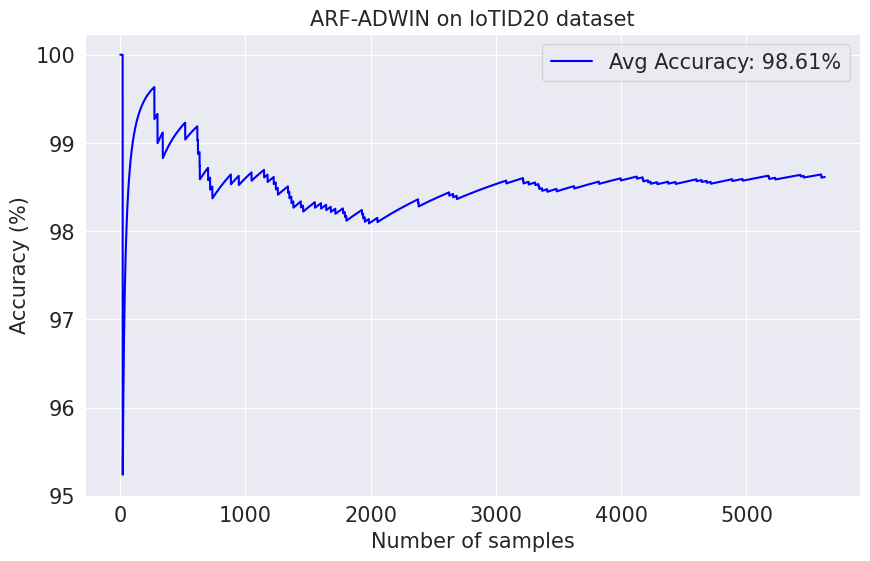

In [ ]:
%%time
# Use the Adaptive Random Forest (ARF) model with ADWIN drift detector
name1 = "ARF-ADWIN"
model1 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = ADWIN()) # Define the model
t, m1 = adaptive_learning(model1, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m1, name1) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 975
Accuracy: 98.22%
Precision: 98.55000000000001%
Recall: 99.59%
F1-score: 99.06%
CPU times: user 8.61 s, sys: 60.4 ms, total: 8.67 s
Wall time: 10.6 s


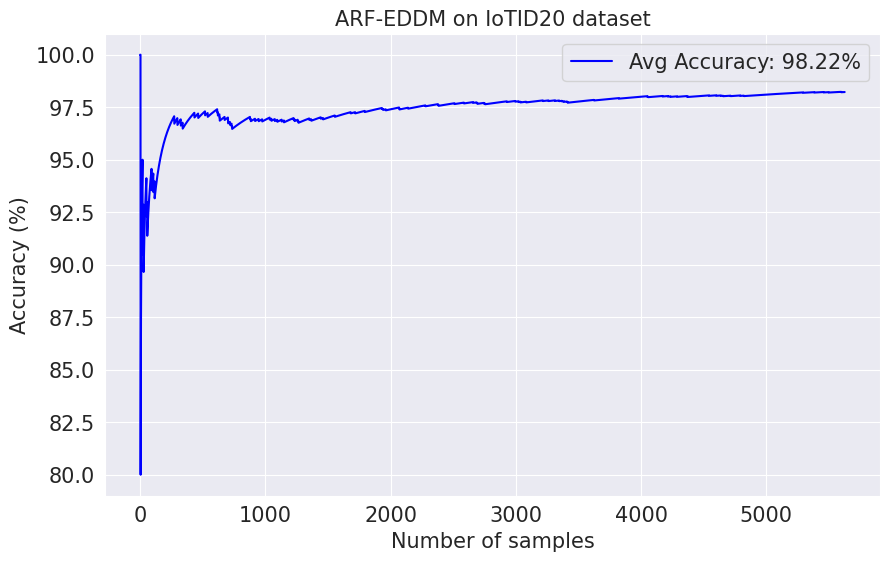

In [ ]:
%%time
# Use the Adaptive Random Forest (ARF) model with EDDM drift detector
name2 = "ARF-EDDM"
model2 = ensemble.AdaptiveRandomForestClassifier(n_models = 3, drift_detector = EDDM()) # Define the model
t, m2 = adaptive_learning(model2, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m2, name2) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 645
Change detected at index 1259
Change detected at index 1738
Change detected at index 2396
Change detected at index 3267
Change detected at index 3954
Change detected at index 4684
Accuracy: 95.5%
Precision: 97.86%
Recall: 97.36%
F1-score: 97.61%
CPU times: user 1.13 s, sys: 37.5 ms, total: 1.16 s
Wall time: 1.91 s


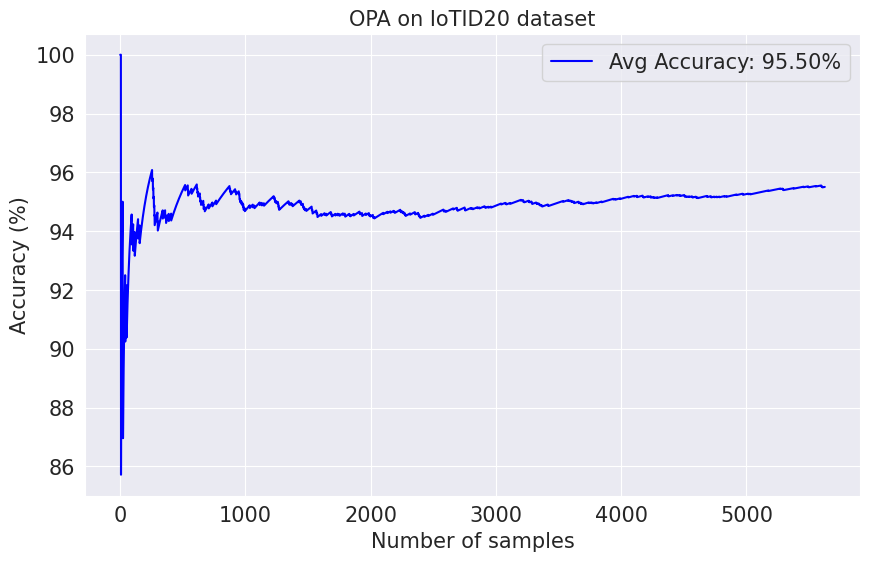

In [ ]:
%%time
# Use the Online Passive-Aggressive (OPA) model
name3 = "OPA"
model3 = linear_model.PAClassifier() # Define the model
t, m3 = adaptive_learning(model3, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m3, name3) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 1682
Accuracy: 98.95%
Precision: 99.21%
Recall: 99.68%
F1-score: 99.45%
CPU times: user 25.1 s, sys: 146 ms, total: 25.2 s
Wall time: 26.3 s


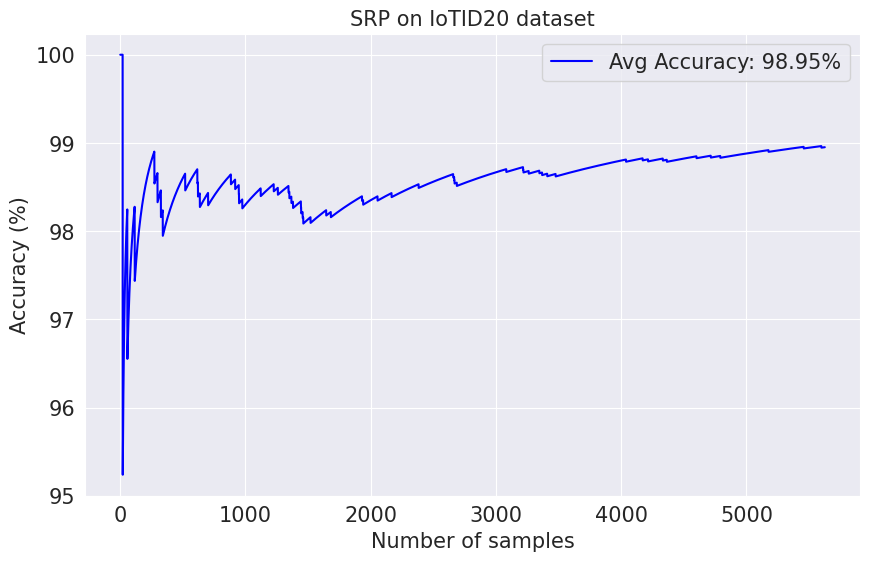

In [ ]:
%%time
# Use the Streaming Random Patches (SRP) model
name4 = "SRP"
model4 = ensemble.SRPClassifier(n_models = 3) # Define the model
t, m4 = adaptive_learning(model4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m4, name4) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 641
Change detected at index 1367
Change detected at index 1912
Accuracy: 95.77%
Precision: 96.53%
Recall: 99.08%
F1-score: 97.78999999999999%
CPU times: user 2.56 s, sys: 104 ms, total: 2.66 s
Wall time: 2.57 s


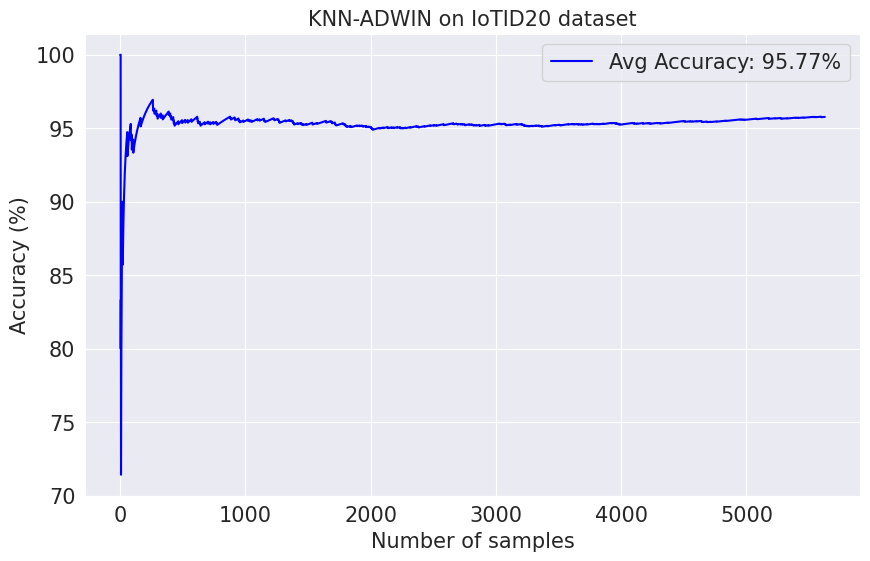

In [ ]:
%%time
# Use the K-Nearest Neighbors (KNN) classifier with ADWIN change detector
name5 = "KNN-ADWIN"
model5 = neighbors.KNNADWINClassifier(window_size=100) # Define the model
t, m5 = adaptive_learning(model5, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m5, name5) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 540
Change detected at index 983
Change detected at index 1418
Change detected at index 1843
Accuracy: 95.82000000000001%
Precision: 96.16%
Recall: 99.55000000000001%
F1-score: 97.82%
CPU times: user 3.67 s, sys: 62.9 ms, total: 3.74 s
Wall time: 3.86 s


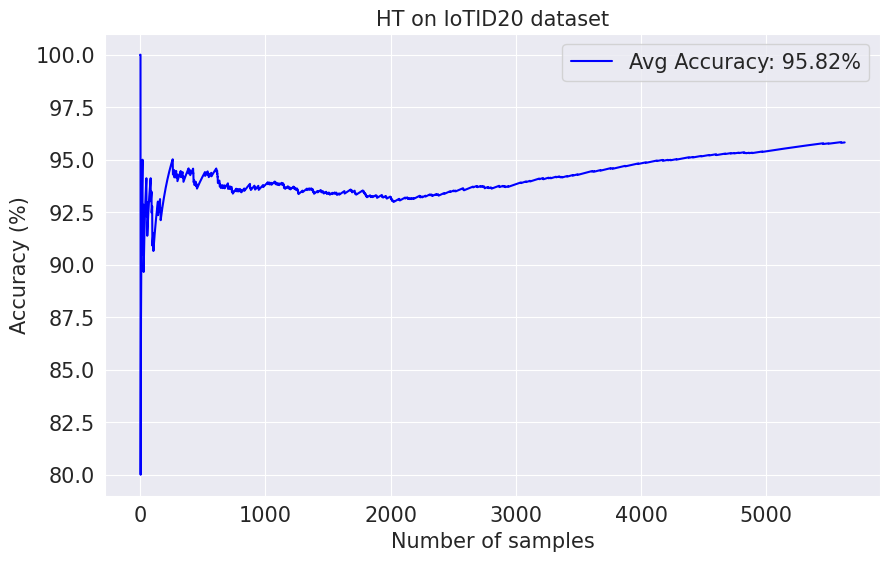

In [ ]:
%%time
# Use the HoeffdingTree model
name6 = "HT"
model6 = tree.HoeffdingTreeClassifier() # Define the model
t, m6 = adaptive_learning(model6, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m6, name6) # Draw the figure of how the real-time accuracy changes with the number of samples

Change detected at index 540
Change detected at index 983
Change detected at index 1418
Change detected at index 1843
Accuracy: 96.32%
Precision: 96.55%
Recall: 99.66000000000001%
F1-score: 98.08%
CPU times: user 2.86 s, sys: 109 ms, total: 2.97 s
Wall time: 2.9 s


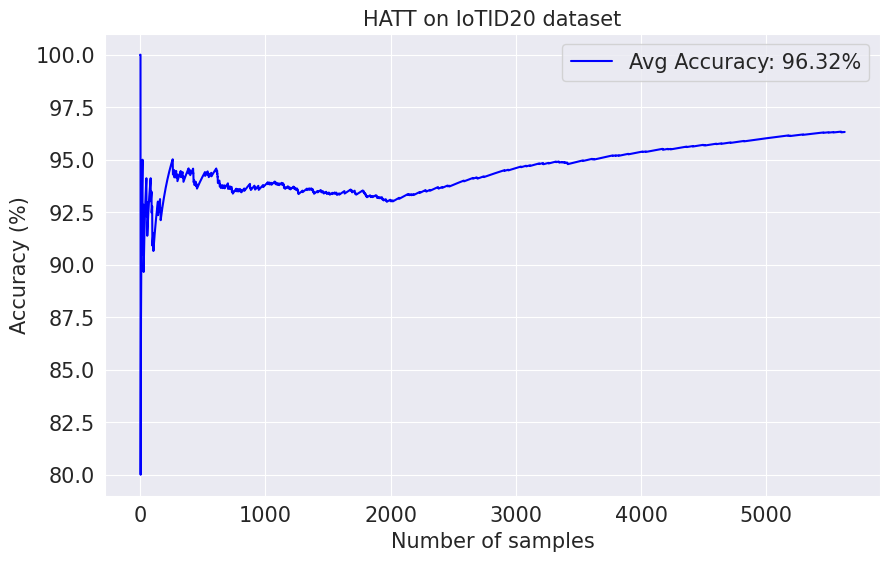

In [ ]:
%%time
# Use the HoeffdingAdaptiveTree model
name7 = "HATT"
model7 = tree.HoeffdingAdaptiveTreeClassifier() # Define the model
t, m7 = adaptive_learning(model7, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m7, name7) # Draw the figure of how the real-time accuracy changes with the number of samples

In [ ]:
# Define the Performance Weighted Probability Averaging Ensemble (PWPAE) model
def PWPAE(X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = ensemble.SRPClassifier(n_models=3) # SRP-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
    hat4 = ensemble.SRPClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # SRP-DDM

    # The four base learners learn the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learner predict the labels
        y_pred1= hat1.predict_one(xi)
        y_prob1= hat1.predict_proba_one(xi) #y_prob1记录模型1预测的概率，类似(0.95,0.1)
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi)
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi)
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi)
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)

        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)

        # Calculate the real-time error rates of four base learners
        e1 = 1-metric1.get()
        e2 = 1-metric2.get()
        e3 = 1-metric3.get()
        e4 = 1-metric4.get()


        ep = 0.001 # The epsilon used to avoid dividing by 0
        # Calculate the weight of each base learner by the reciprocal of its real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        ypro10 = y_prob1.get(0, 0)
        ypro11 = y_prob1.get(1, 0)

        ypro20 = y_prob2.get(0, 0)
        ypro21 = y_prob2.get(1, 0)

        ypro30 = y_prob3.get(0, 0)
        ypro31 = y_prob3.get(1, 0)

        ypro40 = y_prob4.get(0, 0)
        ypro41 = y_prob4.get(1, 0)



        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1

        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get()*100)
        yt.append(yi)
        yp.append(y_pred)

        i=i+1
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    return t, m

Accuracy: 99.2%
Precision: 99.18%
Recall: 99.98%
F1-score: 99.58%
CPU times: user 1min 7s, sys: 274 ms, total: 1min 7s
Wall time: 1min 12s


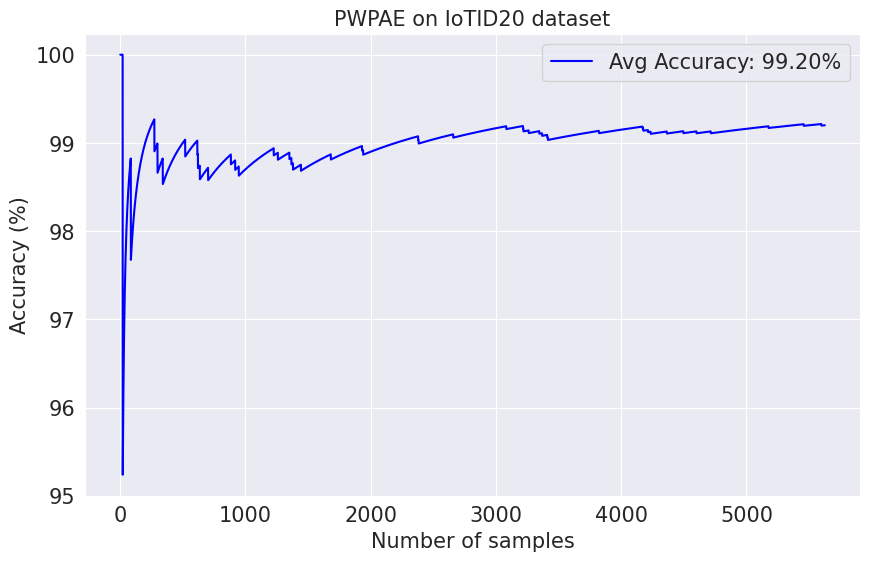

In [ ]:
%%time
# Use the Performance Weighted Probability Averaging Ensemble (PWPAE) model
name8 = "PWPAE"
t, m8 = PWPAE(X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m8, name8) # Draw the figure of how the real-time accuracy changes with the number of samples

In [ ]:
# Define the Window-based Performance Weighted Probability Averaging Ensemble (W-PWPAE) model
# An extension method of the PWPAE model
from river import feature_selection
from river import stats
def MSANA(model1, model2, model3, model4, X_train, y_train, X_test, y_test):
    # Record the real-time accuracy of PWPAE and 4 base learners
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    metric_w1 = []
    metric_w2 = []
    metric_w3 = []
    metric_w4 = []


    i=0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []

    hat1 = model1
    hat2 = model2
    hat3 = model3
    hat4 = model4

    # Define the two feature selections methods: Variance Threshold and Select-K-Best
    selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
    selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)

    # Use EDDM to detect concept drift, it can be replaced with other drift detection methods like ADWIN, DDM, etc.
    eddm = EDDM()
    drift = 0

    # Initial feature selection on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        selector1.learn_one(xi1)

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        selector2.learn_one(xi1,yi1)

    # Train the online models on the training set
    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        xi1 = selector1.transform_one(xi1)
        xi1 = selector2.transform_one(xi1)
        hat1.learn_one(xi1,yi1)
        hat2.learn_one(xi1,yi1)
        hat3.learn_one(xi1,yi1)
        hat4.learn_one(xi1,yi1)

    # Predict the test set
    for xi, yi in stream.iter_pandas(X_test, y_test):
        # The four base learners predict the labels
        xi = selector1.transform_one(xi)
        xi = selector2.transform_one(xi)
        y_pred1= hat1.predict_one(xi)
        y_prob1= hat1.predict_proba_one(xi)
        hat1.learn_one(xi,yi)

        y_pred2= hat2.predict_one(xi)
        y_prob2= hat2.predict_proba_one(xi)
        hat2.learn_one(xi,yi)

        y_pred3= hat3.predict_one(xi)
        y_prob3= hat3.predict_proba_one(xi)
        hat3.learn_one(xi,yi)

        y_pred4= hat4.predict_one(xi)
        y_prob4= hat4.predict_proba_one(xi)
        hat4.learn_one(xi,yi)

        if y_pred1 == yi:
            metric_w1.append(0)
        else:
            metric_w1.append(1)
        if y_pred2 == yi:
            metric_w2.append(0)
        else:
            metric_w2.append(1)
        if y_pred3 == yi:
            metric_w3.append(0)
        else:
            metric_w3.append(1)
        if y_pred4 == yi:
            metric_w4.append(0)
        else:
            metric_w4.append(1)

        # Record their real-time accuracy
        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)


        # Calculate the real-time window error rates of four base learners
        if i<1000:
            e1 = 0
            e2 = 0
            e3 = 0
            e4 = 0
        else:
            e1 = sum(metric_w1[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e2 = sum(metric_w2[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e3 = sum(metric_w3[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])
            e4 = sum(metric_w4[round(0.9*i):i])/len(metric_w1[round(0.9*i):i])


        ep = 0.001 # The epsilon used to avoid dividing by 0

        # Calculate the weight of each base learner by the reciprocal of its window real-time error rate
        ea = 1/(e1+ep)+1/(e2+ep)+1/(e3+ep)+1/(e4+ep)
        w1 = 1/(e1+ep)/ea
        w2 = 1/(e2+ep)/ea
        w3 = 1/(e3+ep)/ea
        w4 = 1/(e4+ep)/ea

        # Make ensemble predictions by the classification probabilities
        if  y_pred1 == 1:
            ypro10=1-y_prob1[1]
            ypro11=y_prob1[1]
        else:
            ypro10=y_prob1[0]
            ypro11=1-y_prob1[0]
        if  y_pred2 == 1:
            ypro20=1-y_prob2[1]
            ypro21=y_prob2[1]
        else:
            ypro20=y_prob2[0]
            ypro21=1-y_prob2[0]
        if  y_pred3 == 1:
            ypro30=1-y_prob3[1]
            ypro31=y_prob3[1]
        else:
            ypro30=y_prob3[0]
            ypro31=1-y_prob3[0]
        if  y_pred4 == 1:
            ypro40=1-y_prob4[1]
            ypro41=y_prob4[1]
        else:
            ypro40=y_prob4[0]
            ypro41=1-y_prob4[0]

        # Calculate the final probabilities of classes 0 & 1 to make predictions
        y_prob_0 = w1*ypro10+w2*ypro20+w3*ypro30+w4*ypro40
        y_prob_1 = w1*ypro11+w2*ypro21+w3*ypro31+w4*ypro41

#         print(str(i)+" "+str(w1)+" "+str(w2)+" "+str(w3)+" "+str(w4)+" "+str(y_prob_0)+" "+str(y_prob_1))

        if (y_prob_0>y_prob_1):
            y_pred = 0
            y_prob = y_prob_0
        else:
            y_pred = 1
            y_prob = y_prob_1

        # Update the real-time accuracy of the ensemble model
        metric = metric.update(yi, y_pred)

        # Detect concept drift
        val = 0
        if yi != y_pred:
            val = 1
        in_drift, in_warning = eddm.update(float(val))

        if in_drift & (i>1000) :
            print(f"Change detected at index {i}")
            drift = 1 # indicating that a drift occurs

        # If a drift is detected
        if drift == 1:
            x_new = X_test[round(0.9*i):i]
            y_new = y_test[round(0.9*i):i]

            # Relearn the online models on the most recent window data (representing new concept data)
            hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
            hat2 = neighbors.KNNADWINClassifier(window_size=100)
            hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
            hat4 = linear_model.PAClassifier() # SRP-DDM

            # Re-select features
            selector1 = feature_selection.VarianceThreshold(threshold = 0.1)
            selector2 = feature_selection.SelectKBest(similarity=stats.PearsonCorr(),k=40)

            for xj, yj in stream.iter_pandas(x_new, y_new):
                selector1 = selector1.learn_one(xj)
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                selector2 = selector2.learn_one(xj, yj)
            for xj, yj in stream.iter_pandas(x_new, y_new):
                xj = selector1.transform_one(xj)
                xa = selector2.transform_one(xj)
                hat1.learn_one(xa,yj)
                hat2.learn_one(xa,yj)
                hat3.learn_one(xa,yj)
                hat4.learn_one(xa,yj)

                if j ==1:
                    print(len(xa))
                    j=0
            drift = 0

        j=1


        t.append(i)
        m.append(metric.get()*100)

        yt.append(yi)
        yp.append(y_pred)

        i=i+1

    # outputs
    print("Accuracy: "+str(round(accuracy_score(yt,yp),4)*100)+"%")
    print("Precision: "+str(round(precision_score(yt,yp),4)*100)+"%")
    print("Recall: "+str(round(recall_score(yt,yp),4)*100)+"%")
    print("F1-score: "+str(round(f1_score(yt,yp),4)*100)+"%")
    print(metric1.get()*100)
    print(metric2.get()*100)
    print(metric3.get()*100)
    print(metric4.get()*100)
    return t, m

Accuracy: 99.11%
Precision: 99.08%
Recall: 99.98%
F1-score: 99.53%
98.73822640838813
99.20028434334459
98.16953971921095
96.53456548782655
CPU times: user 29.3 s, sys: 149 ms, total: 29.5 s
Wall time: 29.6 s


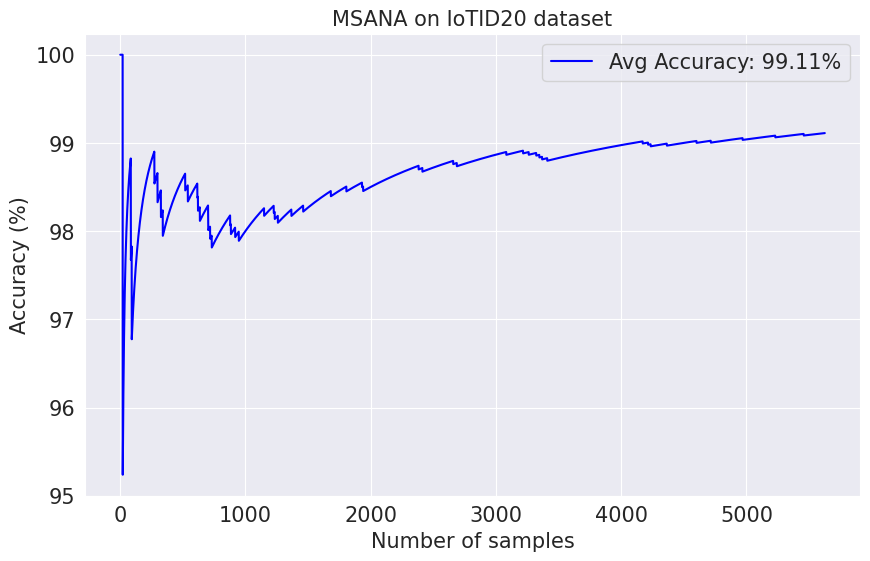

In [ ]:
%%time
# Use the Multi-Stage Automated Network Analytics (MSANA) model

# Select the four base online models, they can be changed based on the performance of the models
bm1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
bm2 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=DDM(),warning_detector=DDM()) # ARF-DDM
bm3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
bm4 = tree.ExtremelyFastDecisionTreeClassifier(grace_period=150,
    split_confidence=5e-5,
    tie_threshold=0.1,
    max_depth=15,
    min_samples_reevaluate=10,
    leaf_prediction='nba',
    binary_split=True,
    nominal_attributes=None,
    max_size=1000,

) # EFDT

name9 = "MSANA"
t, m9 = MSANA(bm1, bm2, bm3, bm4, X_train, y_train, X_test, y_test) # Learn the model on the dataset
acc_fig(t, m9, name9) # Draw the figure of how the real-time accuracy changes with the number of samples

Accuracy: 99.75%
Precision: 99.74%
Recall: 100.0%
F1-score: 99.87%
CPU times: user 18.2 s, sys: 156 ms, total: 18.3 s
Wall time: 18.4 s


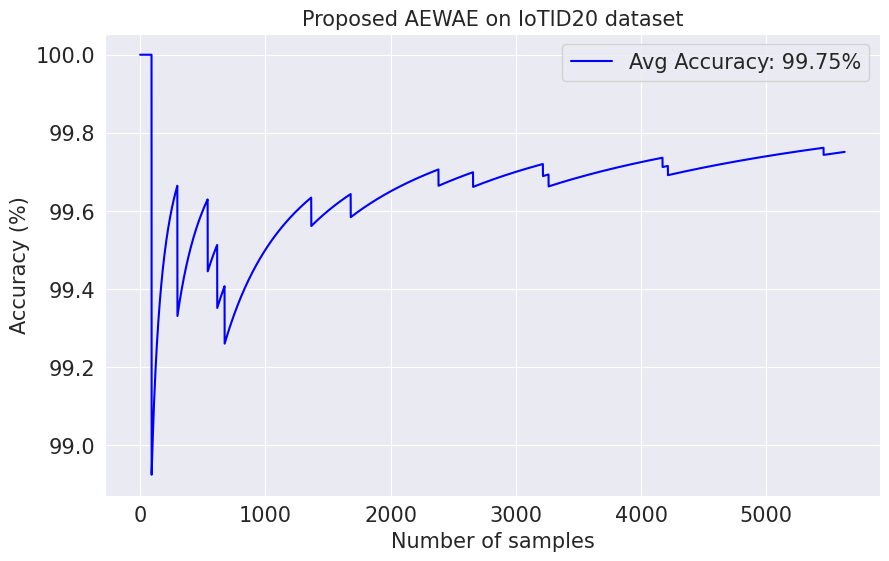

In [ ]:
%%time
name = "Proposed AEWAE"
t, m = AEWAE(X_train, y_train, X_test, y_test, 0.25315504363043334) # Learn the model on the dataset
acc_fig(t, m, name) # Draw the figure of how the real-time accuracy changes with the number of samples

### Model comparison

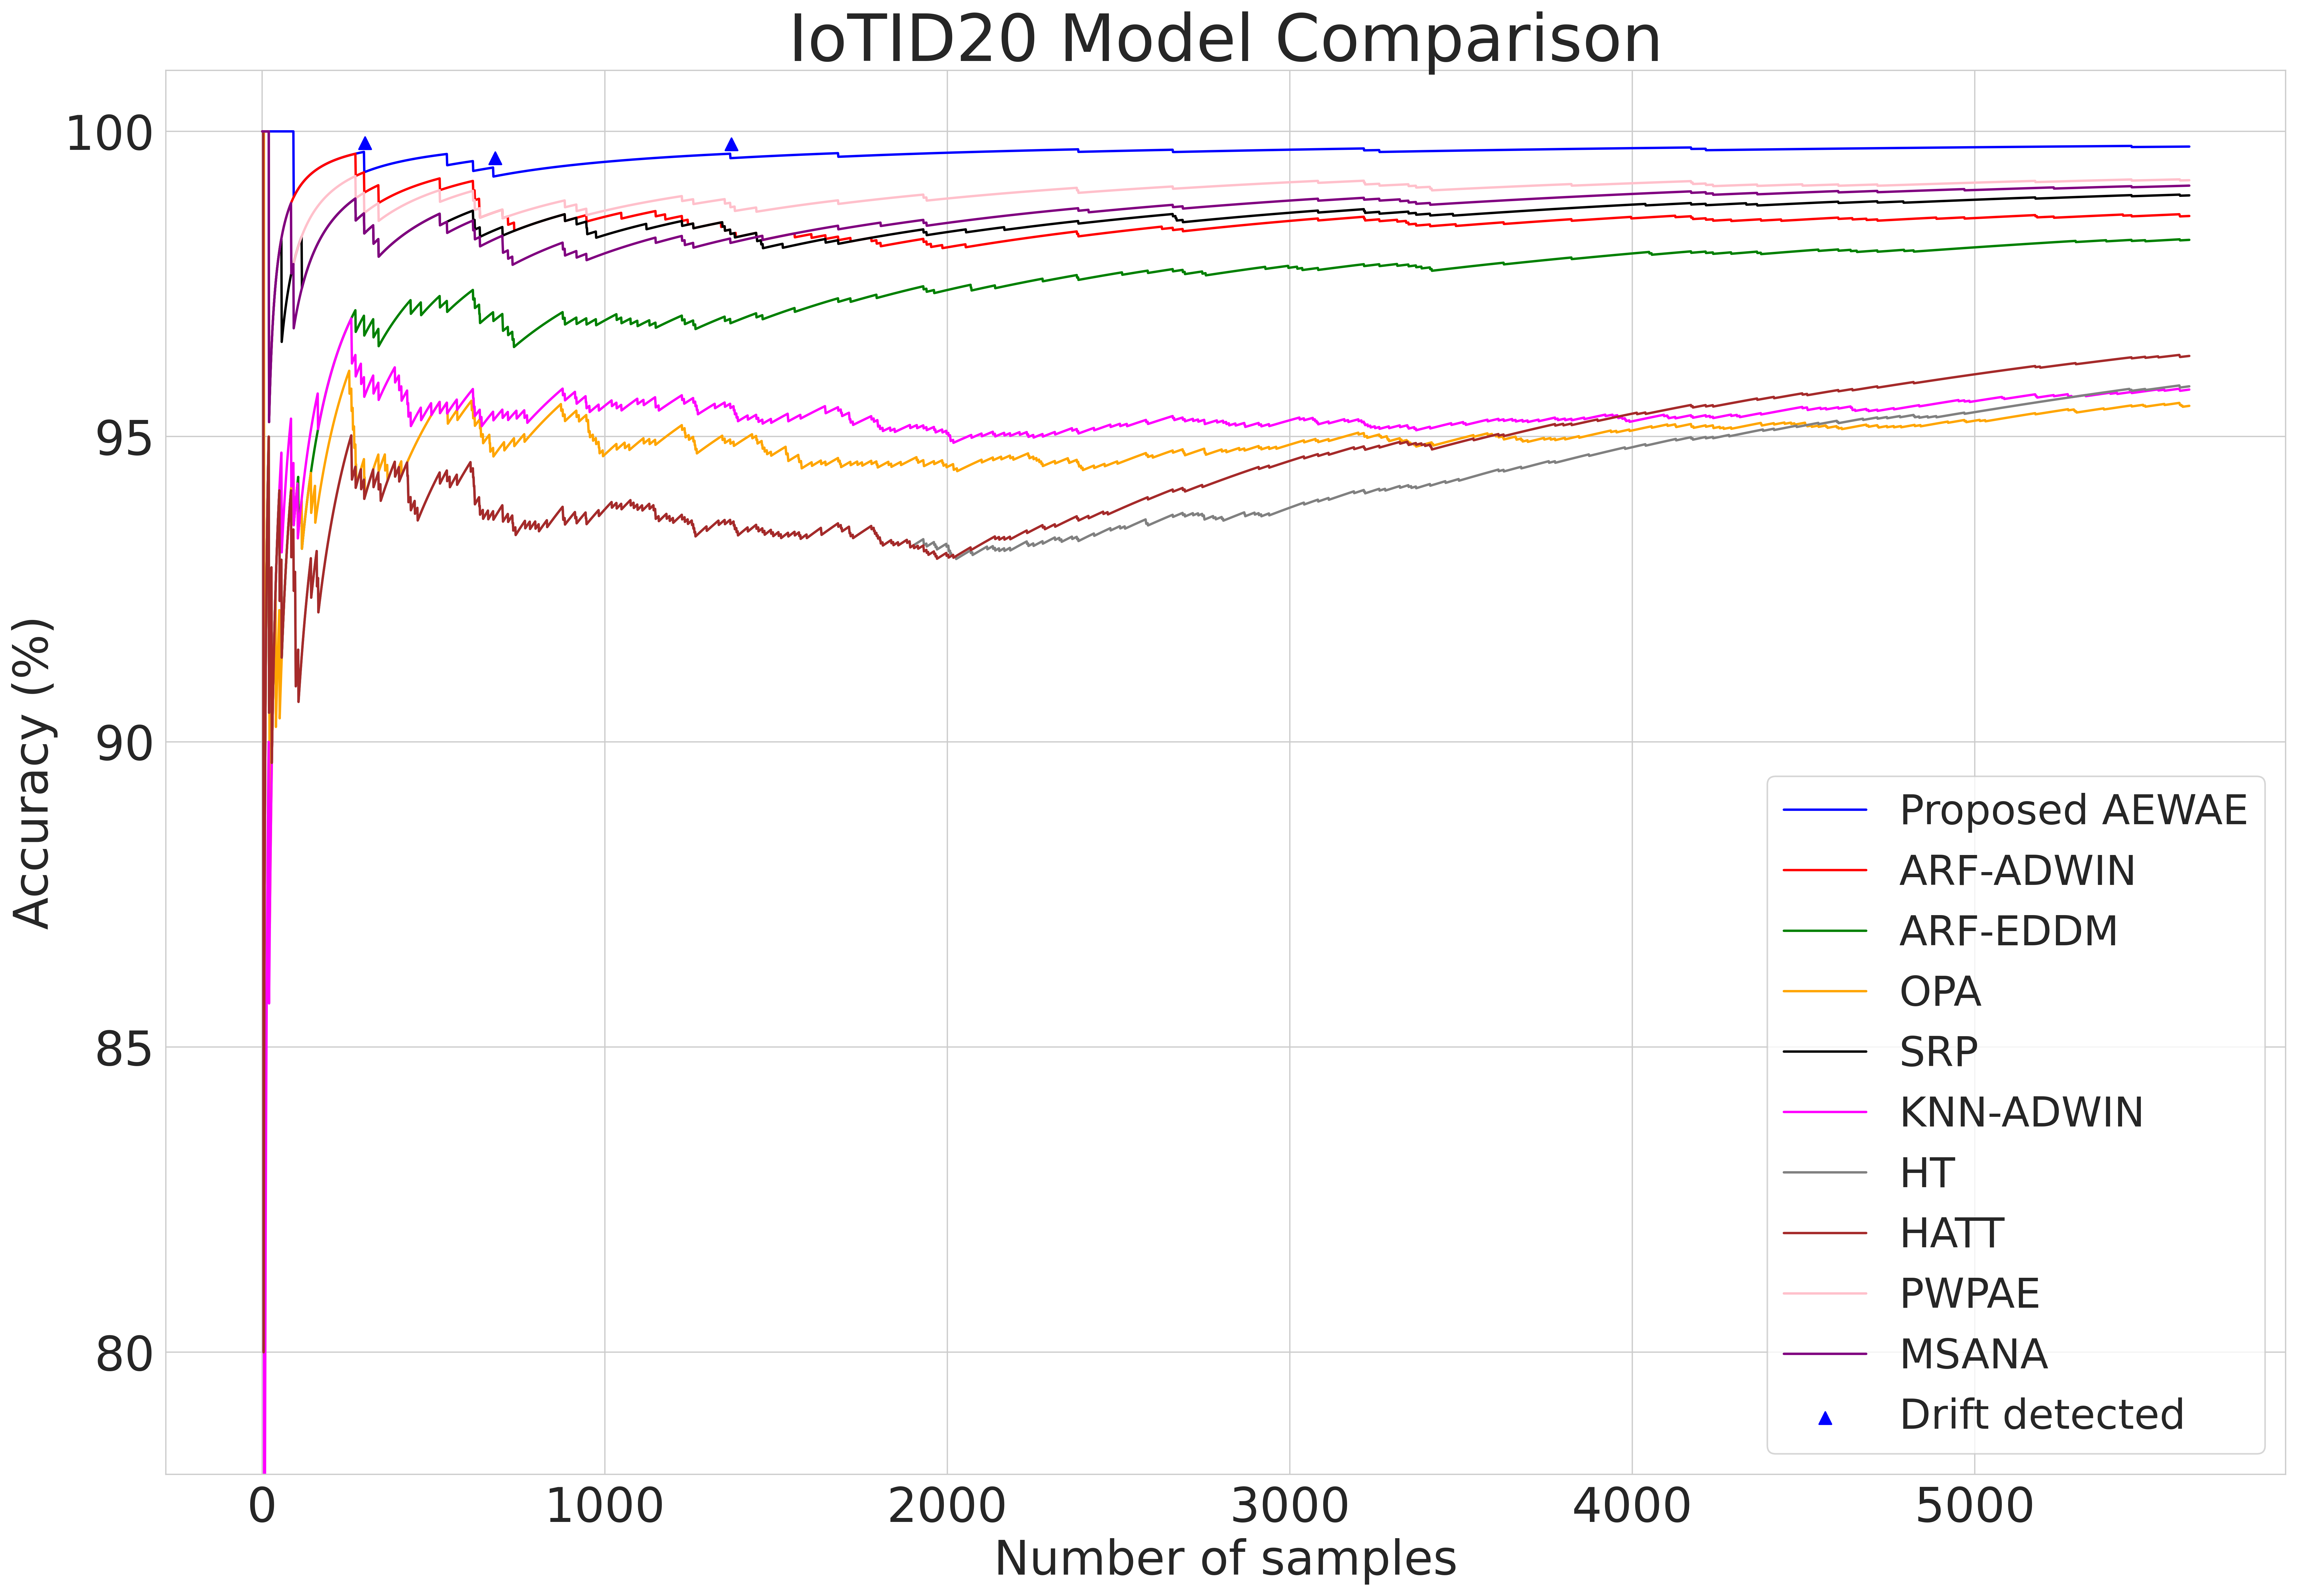

In [ ]:
# Draw a comprehensive figure to compare the performance of all models
# https://matplotlib.org/stable/gallery/color/named_colors.html
plt.rcParams.update({'font.size': 30})
plt.figure(1,figsize=(24,16), dpi=400)
sns.set_style("whitegrid")
plt.clf()

# Plot the accuracy change of each learner
plt.plot(t,m,'-b',label=name)
# plt.plot(t,m0,'pink',label=name0')
plt.plot(t,m1,'-r',label=name1)
plt.plot(t,m2,'-g',label=name2)
plt.plot(t,m3,'orange',label=name3)
plt.plot(t,m4,'black',label=name4)
plt.plot(t,m5,'magenta',label=name5)
plt.plot(t,m6,'grey',label=name6)
plt.plot(t,m7,'brown',label=name7)
plt.plot(t,m8,'pink',label=name8)
plt.plot(t,m9,'purple',label=name9)

plt.scatter(300, 99.81, marker='^', color='b', s=60, label='Drift detected')
plt.scatter(680, 99.56, marker='^', color='b', s=60)
plt.scatter(1370, 99.79, marker='^', color='b', s=60)

plt.legend(loc='lower right', fontsize=26)
plt.ylim(78, 101)
plt.title('IoTID20 Model Comparison', fontsize=41)
plt.xlabel('Number of samples')
plt.ylabel('Accuracy (%)')

plt.savefig('/content/drive/My Drive/AEWAE/IoTID20.eps', format='eps', dpi=400)
plt.draw()

### PDF(Probability Density Function)

In [ ]:
def aewae_pdf(X_train, y_train, X_test, y_test, alpha):
    metric = metrics.Accuracy()
    metric1 = metrics.Accuracy()
    metric2 = metrics.Accuracy()
    metric3 = metrics.Accuracy()
    metric4 = metrics.Accuracy()

    cumulative_error1 = 0
    cumulative_error2 = 0
    cumulative_error3 = 0
    cumulative_error4 = 0

    i = 0
    t = []
    m = []
    m1 = []
    m2 = []
    m3 = []
    m4 = []
    yt = []
    yp = []
    inference_times = []


    hat1 = ensemble.AdaptiveRandomForestClassifier(n_models=3) # ARF-ADWIN
    hat2 = neighbors.KNNADWINClassifier(window_size=100) # KNN-ADWIN
    hat3 = ensemble.AdaptiveRandomForestClassifier(n_models=3,drift_detector=EDDM(),warning_detector=EDDM()) # ARF-EDDM
    hat4 = linear_model.PAClassifier() # OPA

    for xi1, yi1 in stream.iter_pandas(X_train, y_train):
        hat1.learn_one(xi1, yi1)
        hat2.learn_one(xi1, yi1)
        hat3.learn_one(xi1, yi1)
        hat4.learn_one(xi1, yi1)

    for xi, yi in stream.iter_pandas(X_test, y_test):
        start_time = time.time()
        y_pred1 = hat1.predict_one(xi)
        y_prob1 = hat1.predict_proba_one(xi)
        hat1.learn_one(xi, yi)

        y_pred2 = hat2.predict_one(xi)
        y_prob2 = hat2.predict_proba_one(xi)
        hat2.learn_one(xi, yi)

        y_pred3 = hat3.predict_one(xi)
        y_prob3 = hat3.predict_proba_one(xi)
        hat3.learn_one(xi, yi)

        y_pred4 = hat4.predict_one(xi)
        y_prob4 = hat4.predict_proba_one(xi)
        hat4.learn_one(xi, yi)

        metric1 = metric1.update(yi, y_pred1)
        metric2 = metric2.update(yi, y_pred2)
        metric3 = metric3.update(yi, y_pred3)
        metric4 = metric4.update(yi, y_pred4)

        error1 = 1 if y_pred1 != yi else 0
        error2 = 1 if y_pred2 != yi else 0
        error3 = 1 if y_pred3 != yi else 0
        error4 = 1 if y_pred4 != yi else 0

        cumulative_error1 = alpha * cumulative_error1 + (1 - alpha) * error1
        cumulative_error2 = alpha * cumulative_error2 + (1 - alpha) * error2
        cumulative_error3 = alpha * cumulative_error3 + (1 - alpha) * error3
        cumulative_error4 = alpha * cumulative_error4 + (1 - alpha) * error4

        ewa_error_rate1 = cumulative_error1 / (1 - alpha ** (i + 1))
        ewa_error_rate2 = cumulative_error2 / (1 - alpha ** (i + 1))
        ewa_error_rate3 = cumulative_error3 / (1 - alpha ** (i + 1))
        ewa_error_rate4 = cumulative_error4 / (1 - alpha ** (i + 1))


        ep = 0.001
        ea = 1 / (ewa_error_rate1 + ep) + 1 / (ewa_error_rate2 + ep) + 1 / (ewa_error_rate3 + ep) + 1 / (
                ewa_error_rate4 + ep)
        w1 = 1 / (ewa_error_rate1 + ep) / ea
        w2 = 1 / (ewa_error_rate2 + ep) / ea
        w3 = 1 / (ewa_error_rate3 + ep) / ea
        w4 = 1 / (ewa_error_rate4 + ep) / ea


        ypro10 = y_prob1.get(0, 0)
        ypro11 = y_prob1.get(1, 0)

        ypro20 = y_prob2.get(0, 0)
        ypro21 = y_prob2.get(1, 0)

        ypro30 = y_prob3.get(0, 0)
        ypro31 = y_prob3.get(1, 0)

        ypro40 = y_prob4.get(0, 0)
        ypro41 = y_prob4.get(1, 0)


        y_prob_0 = w1 * ypro10 + w2 * ypro20 + w3 * ypro30 + w4 * ypro40
        y_prob_1 = w1 * ypro11 + w2 * ypro21 + w3 * ypro31 + w4 * ypro41

        if y_prob_0 > y_prob_1:
            y_pred = 0
        else:
            y_pred = 1

        end_time = time.time()
        inference_time = end_time - start_time
        inference_times.append(inference_time)


        metric = metric.update(yi, y_pred)

        t.append(i)
        m.append(metric.get() * 100)
        yt.append(yi)
        yp.append(y_pred)

        i = i + 1



    return t, m, yt, yp, inference_times

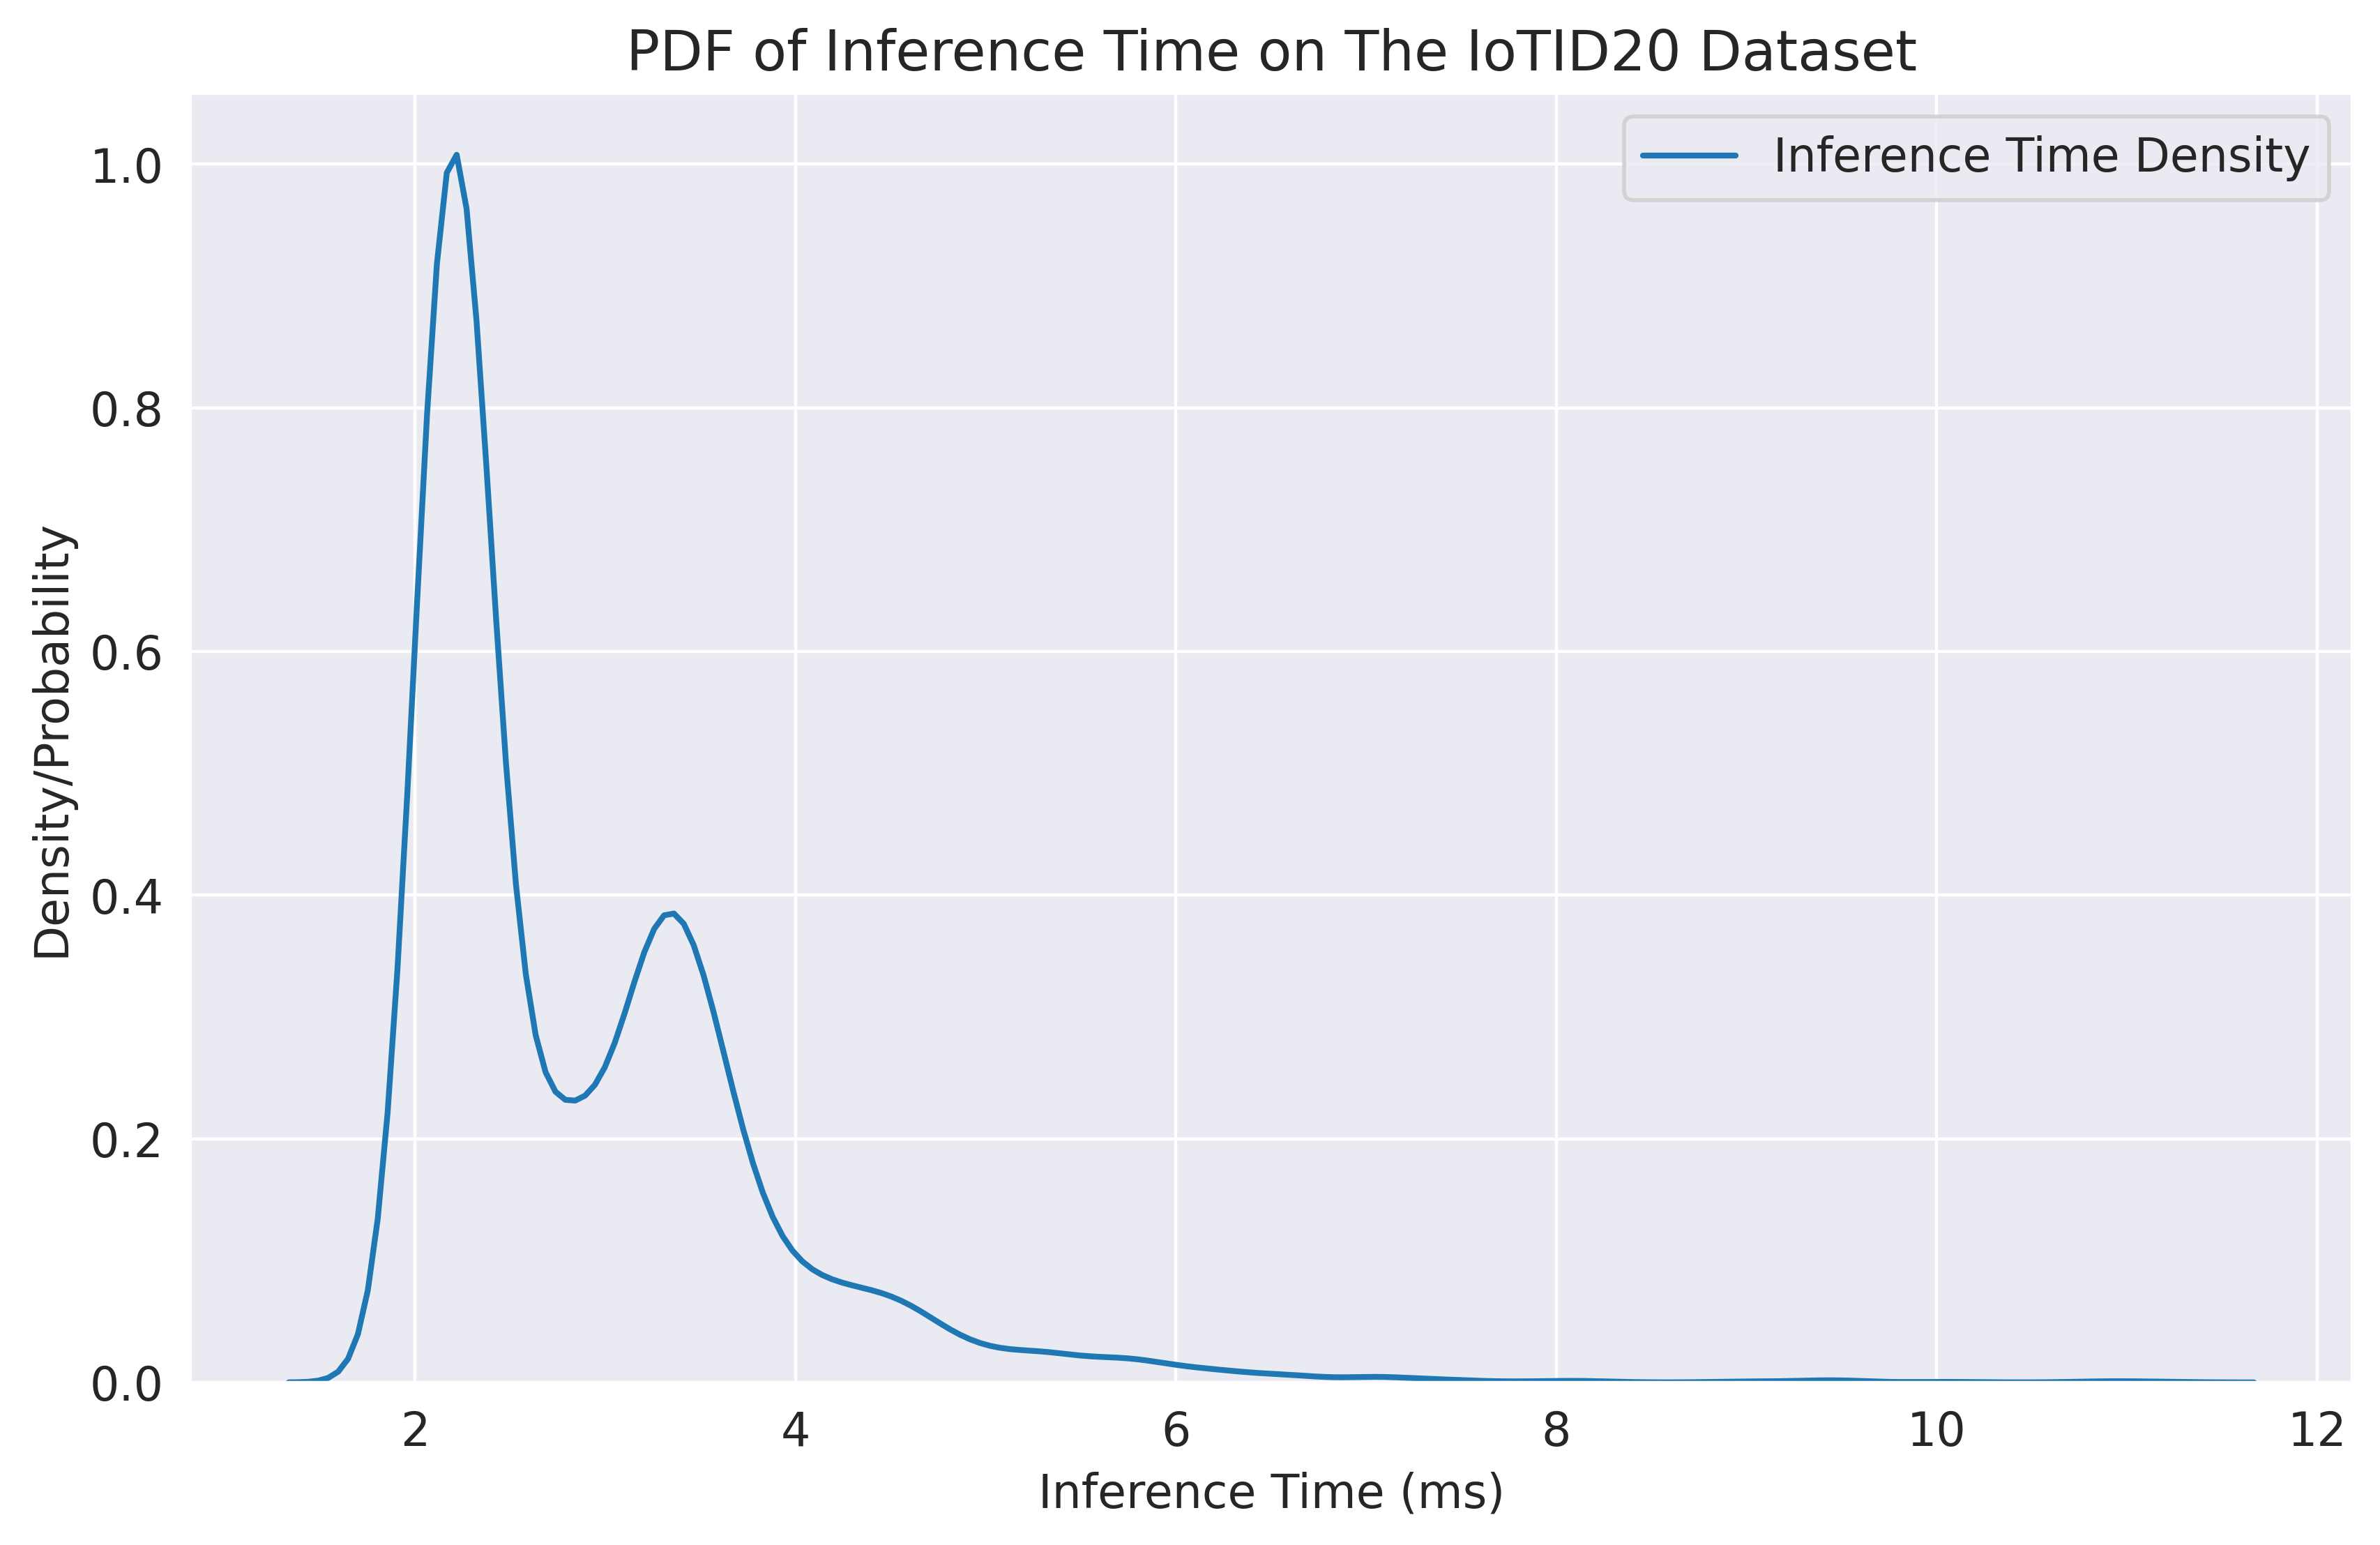

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
# Set the global font size
plt.rcParams.update({'font.size': 12})

# Call the AEWAE function and get the inference times
t, m, yt, yp, inference_times = aewae_pdf(X_train, y_train, X_test, y_test, 0.25315504363043334)

# Convert inference times from seconds to milliseconds
inference_times_ms = [time * 1000 for time in inference_times]

# Create a figure with a specified size (in inches) and resolution (DPI)
plt.figure(figsize=(10, 6), dpi=400)

# Plot the probability density function for the inference times
sns.kdeplot(inference_times_ms, label='Inference Time Density')
plt.xlabel('Inference Time (ms)')
plt.ylabel('Density/Probability')
plt.title('PDF of Inference Time on The IoTID20 Dataset')
plt.legend()
#plt.savefig('/content/drive/My Drive/AEWAE/IoTID20_pdf2.eps', format='eps', dpi=400)
# Show the plot with the adjusted size, font size, time unit, title, and higher resolution
plt.show()


### CDF(Cumulative Distribution Function)

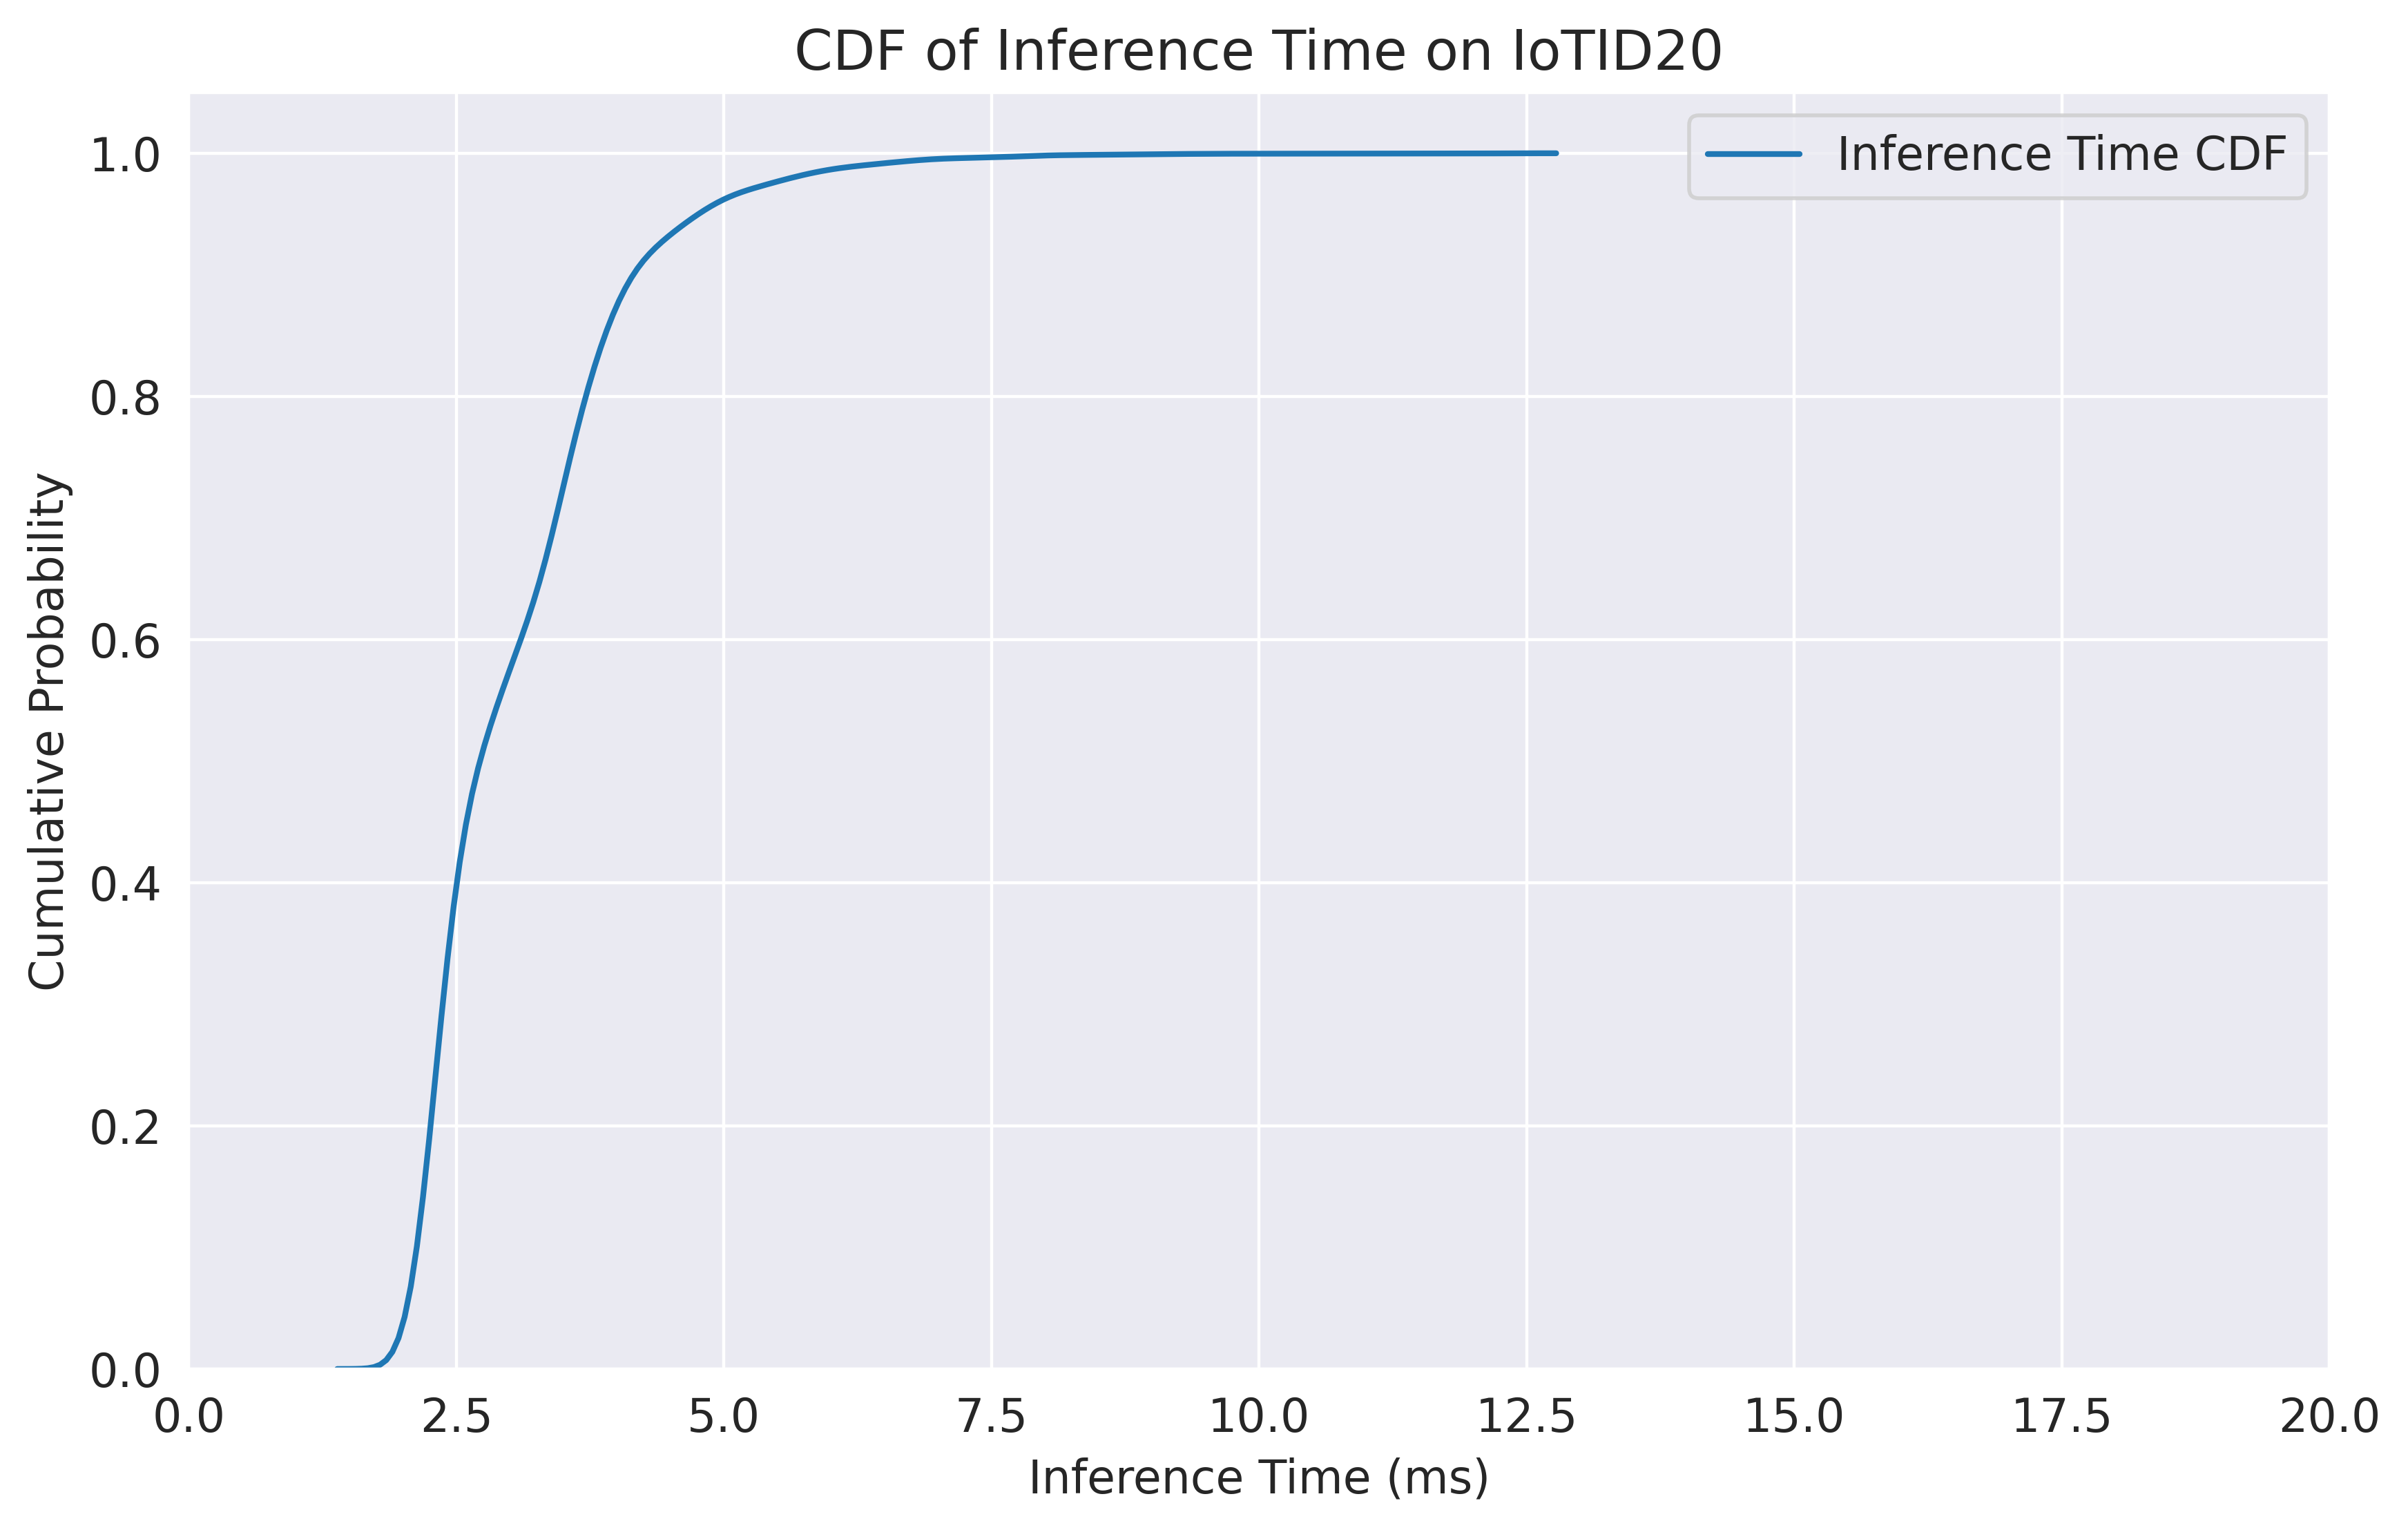

In [ ]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Continue with the setup as before...
sns.set_style("darkgrid")
plt.rcParams.update({'font.size': 12})

# Call the AEWAE function and get the inference times
t, m, yt, yp, inference_times = aewae_pdf(X_train, y_train, X_test, y_test, 0.25315504363043334)

# Convert inference times from seconds to milliseconds
inference_times_ms = [time * 1000 for time in inference_times]

# Create a figure with a specified size (in inches) and resolution (DPI)
plt.figure(figsize=(10, 6), dpi=400)

# Plot the Cumulative Distribution Function for the inference times
# Note the addition of the `cumulative=True` parameter
sns.kdeplot(inference_times_ms, cumulative=True, label='Inference Time CDF')

plt.xlabel('Inference Time (ms)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Inference Time on IoTID20')
plt.legend(loc='upper right')

plt.savefig('/content/drive/My Drive/AEWAE/IoTID20_cdf.eps', format='eps', dpi=400)
# Set the x-axis limit to 0-20ms
plt.xlim(0, 20)

# Show the plot with the adjusted size, font size, time unit, title, and higher resolution
plt.show()
